In [18]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Construcción del Modelo

In [19]:
import torch.nn as nn
from torchinfo import summary

In [20]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        ##  ERROR AQUI
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

In [21]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh() # [-1,1]

        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.gen(x)

In [22]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

## Training

In [36]:
# HYPERPARAMETERS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hyperparams = pd.read_csv('hyperparameters.csv')
display(hyperparams)

LEARNING_RATE = 2e-4
BATCH_SIZE = 50
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 1000
FEATURES_DISC = 64
FEATURES_GEN = 64

cpu


,LEARNING_RATE,BATCH_SIZE,IMAGE_SIZE,CHANNELS_IMG,Z_DIM,NUM_EPOCHS,FEATURES_DISC,FEATURES_GEN,CURRENT_EPOCH
0,0.0002,50,64,3,100,1000,64,64,0


## Lectura de Datos

In [24]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))
    ])

In [25]:
data = datasets.ImageFolder('data/monet', transform=transform)

Validamos que podemos leer las imágenes

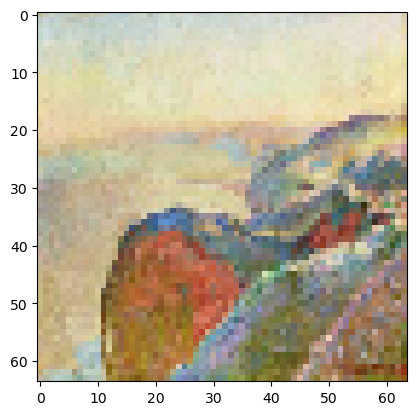

In [26]:
image, _ = data[0]
plt.imshow(image.permute(1, 2, 0))

In [27]:
# Corroboramos que el dataset tiene 300 imágenes
len(data)

300

## Split de Datos

In [28]:
def split_data(data, test_proportion):
    registers = len(data)
    test_size = int(np.round(test_proportion*registers))
    train_data, test_data = torch.utils.data.random_split(data, [registers - test_size, test_size])
    return train_data, test_data

In [29]:
train_data, test_data = split_data(data, 0.1)
len(train_data), len(test_data)

(270, 30)

## Batch de Datos

In [30]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

def load_data(data, batch_size):
    return DataLoader(data, batch_size=batch_size, shuffle=True)

In [31]:
train_loader = load_data(train_data, BATCH_SIZE)
print(f"Batch size: {BATCH_SIZE}")

Batch size: 50


In [32]:
def view_sample(tensor_img, num_images = 9, size=(3, 3)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=3)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

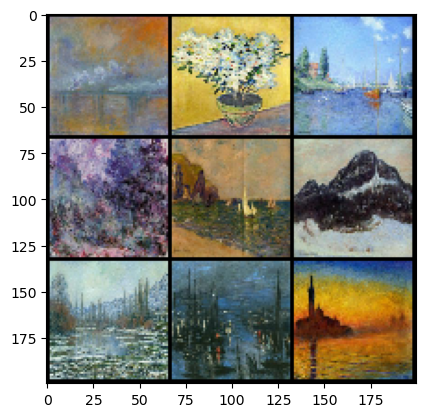

In [33]:
images, _ = next(iter(train_loader))
view_sample(images)

Epoch [0/1000] Batch 0/6                 Loss D: 0.6912, loss G: 0.7998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


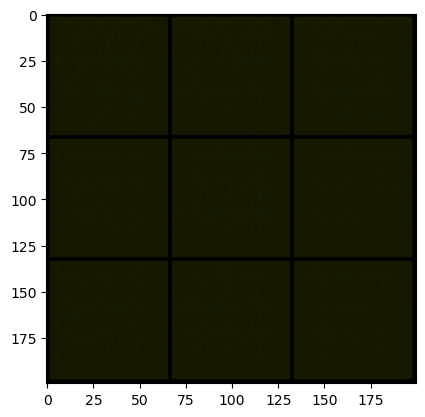

Epoch [1/1000] Batch 0/6                 Loss D: 0.4673, loss G: 1.1541
Epoch [2/1000] Batch 0/6                 Loss D: 0.3073, loss G: 1.4914
Epoch [3/1000] Batch 0/6                 Loss D: 0.2111, loss G: 1.7997
Epoch [4/1000] Batch 0/6                 Loss D: 0.1487, loss G: 2.0737
Epoch [5/1000] Batch 0/6                 Loss D: 0.1124, loss G: 2.3279
Epoch [6/1000] Batch 0/6                 Loss D: 0.0898, loss G: 2.5305
Epoch [7/1000] Batch 0/6                 Loss D: 0.0700, loss G: 2.7583
Epoch [8/1000] Batch 0/6                 Loss D: 0.0611, loss G: 2.9544
Epoch [9/1000] Batch 0/6                 Loss D: 0.0485, loss G: 3.1168
Epoch [10/1000] Batch 0/6                 Loss D: 0.0407, loss G: 3.3038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


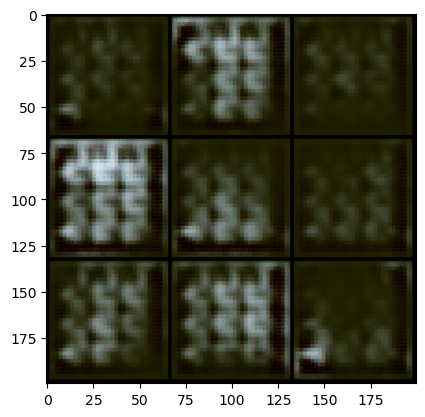

Epoch [11/1000] Batch 0/6                 Loss D: 0.0335, loss G: 3.4631
Epoch [12/1000] Batch 0/6                 Loss D: 0.0292, loss G: 3.6060
Epoch [13/1000] Batch 0/6                 Loss D: 0.0255, loss G: 3.7242
Epoch [14/1000] Batch 0/6                 Loss D: 1.7446, loss G: 3.2710
Epoch [15/1000] Batch 0/6                 Loss D: 0.1435, loss G: 2.3625
Epoch [16/1000] Batch 0/6                 Loss D: 0.3883, loss G: 1.8790
Epoch [17/1000] Batch 0/6                 Loss D: 0.7214, loss G: 3.0121
Epoch [18/1000] Batch 0/6                 Loss D: 0.7474, loss G: 1.1423
Epoch [19/1000] Batch 0/6                 Loss D: 0.6864, loss G: 0.9397
Epoch [20/1000] Batch 0/6                 Loss D: 0.6194, loss G: 0.9914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


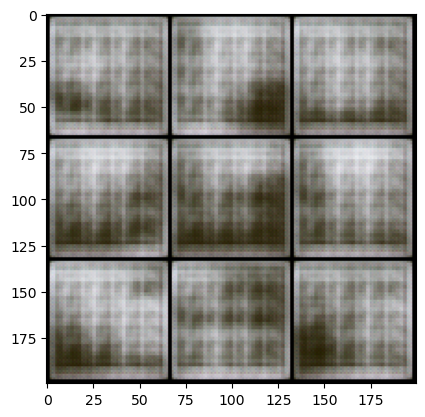

Epoch [21/1000] Batch 0/6                 Loss D: 0.5128, loss G: 1.1397
Epoch [22/1000] Batch 0/6                 Loss D: 0.3767, loss G: 1.3947
Epoch [23/1000] Batch 0/6                 Loss D: 0.3839, loss G: 1.6520
Epoch [24/1000] Batch 0/6                 Loss D: 0.3087, loss G: 2.9099
Epoch [25/1000] Batch 0/6                 Loss D: 0.4263, loss G: 1.9750
Epoch [26/1000] Batch 0/6                 Loss D: 0.6668, loss G: 1.2142
Epoch [27/1000] Batch 0/6                 Loss D: 0.5082, loss G: 1.5002
Epoch [28/1000] Batch 0/6                 Loss D: 0.5790, loss G: 1.2835
Epoch [29/1000] Batch 0/6                 Loss D: 0.5368, loss G: 1.2927
Epoch [30/1000] Batch 0/6                 Loss D: 0.6042, loss G: 1.5458


KeyboardInterrupt: 

In [34]:
from torch.utils.tensorboard import SummaryWriter
import os

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Check if there are saved models
saved_models = [file for file in os.listdir() if file.endswith('.pt')]
if saved_models:
    # Get the most recent saved models
    latest_gen_model = max(saved_models, key=os.path.getctime)
    latest_disc_model = latest_gen_model.replace('gen', 'disc')
    
    # Load the most recent models
    gen.load_state_dict(torch.load(latest_gen_model))
    disc.load_state_dict(torch.load(latest_disc_model))
    print(f"Loaded most recent models: {latest_gen_model}, {latest_disc_model}")
else:
    print("No saved models found. Starting training from scratch.")
    initialize_weights(gen)
    initialize_weights(disc)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
    if epoch % 10 == 0:
        torch.save(gen.state_dict(), f"gen/gen_{epoch}.pt")
        torch.save(disc.state_dict(), f"disc/disc_{epoch}.pt")
        view_sample(fake)


In [ ]:
view_sample(fake)